# DATA 607 - Machine Learning

## Class 6 &mdash; 2025.05.03

### Tree-structured models

In [273]:
import numpy as np
import pandas as pd
from icecream import ic
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    RepeatedKFold,
)
from sklearn.linear_model import (
    Lasso,
    LogisticRegression,
    LinearRegression,
    Ridge,
)
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from collections import Counter

In [61]:
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('svg')  # Use 'pdf' instead if preferred

In [ ]:
def make_data(n, *, rng=None):
    rng = np.random.default_rng(rng)
    x = rng.uniform(size=n)
    y = 10 * x * (x - 0.2) * (x - 0.9) + 10 * x * 0.02 * rng.normal(size=n)
    return x, y

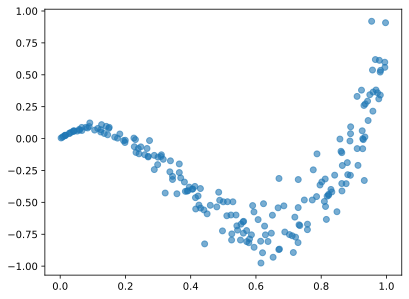

In [136]:
x, y = make_data(200, rng=np.random.default_rng(0))
X = x.reshape(-1, 1)
plt.scatter(x, y, alpha=0.6)
plt.show()

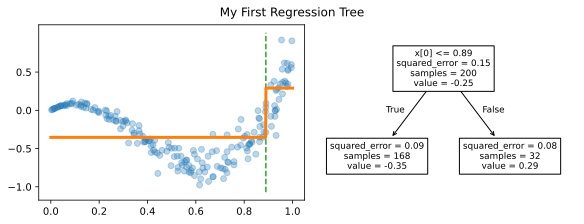

In [137]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

model = DecisionTreeRegressor(max_depth=1)
model.fit(X, y)
tree = model.tree_

fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), layout="constrained")
fig.suptitle("My First Regression Tree")
u = np.linspace(0, 1, 1000)
a0.scatter(x, y, alpha=0.3)
a0.vlines(
    [t for f, t in zip(tree.feature, tree.threshold) if f >= 0],
    *a0.get_ylim(),
    color=[
        f"C{d + 1}" for d, f in zip(tree.compute_node_depths(), tree.feature) if f >= 0
    ],
    linestyles="--",
)
a0.plot(u, model.predict(u.reshape(-1, 1)), "C1", lw=3, label="model")
a0.set_yticks([-0.5, 0, 0.5, -1])
plot_tree(model, ax=a1, precision=2)
plt.show()

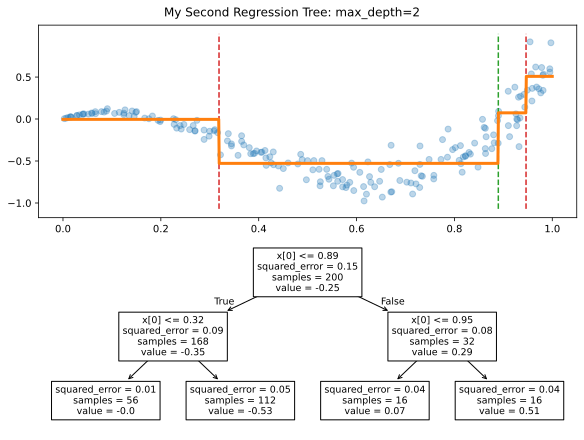

In [146]:
model = DecisionTreeRegressor(max_depth=2)
model.fit(X, y)
tree = model.tree_

fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), layout="constrained")
fig.suptitle("My Second Regression Tree: max_depth=2")
u = np.linspace(0, 1, 1000)
a0.scatter(x, y, alpha=0.3)
a0.vlines(
    [t for f, t in zip(tree.feature, tree.threshold) if f >= 0],
    *a0.get_ylim(),
    color=[
        f"C{d + 1}" for d, f in zip(tree.compute_node_depths(), tree.feature) if f >= 0
    ],
    linestyles="--",
)
a0.plot(u, model.predict(u.reshape(-1, 1)), "C1", lw=3, label="model")
a0.set_yticks([-0.5, 0, 0.5, -1])
plot_tree(model, ax=a1, precision=2)
plt.show()

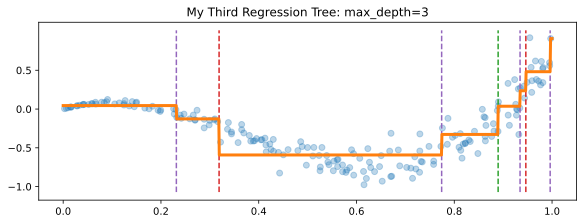

In [162]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X, y)
tree = model.tree_

fig, a0 = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 3), layout="constrained", sharey=True
)
u = np.linspace(0, 1, 1000)
a0.scatter(x, y, alpha=0.3)
a0.vlines(
    [t for f, t in zip(tree.feature, tree.threshold) if f >= 0],
    *a0.get_ylim(),
    color=[
        f"C{d + 1}" for d, f in zip(tree.compute_node_depths(), tree.feature) if f >= 0
    ],
    linestyles="--",
)
a0.plot(u, model.predict(u.reshape(-1, 1)), "C1", lw=3, label="model")
a0.set_yticks([-0.5, 0, 0.5, -1])
a0.set_title("My Third Regression Tree: max_depth=3")
plt.show()

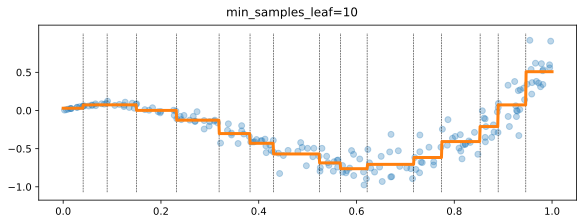

In [147]:
model = DecisionTreeRegressor(min_samples_leaf=10)
model.fit(X, y)
tree = model.tree_

fig, a0 = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 3), layout="constrained", sharey=True
)
fig.suptitle("min_samples_leaf=10")
u = np.linspace(0, 1, 1000)
a0.scatter(x, y, alpha=0.3)
a0.vlines(
    [t for f, t in zip(tree.feature, tree.threshold) if f >= 0],
    *a0.get_ylim(),
    color="k",
    lw=0.5,
    linestyles="--",
)
a0.plot(u, model.predict(u.reshape(-1, 1)), "C1", lw=3, label="model")
a0.set_yticks([-0.5, 0, 0.5, -1])
plt.show()

### Fitting regression trees to $1$-dimensional data

- Regression trees are fit ***recursively***.

#### The constant regressor

- Let
  $$\mathcal{D}=\{(x_i, y_i) : i < n\}$$
  be a training set.

- Define the ***constant regressor***:
  $$
  \hat{f}_0(x\mid \mathcal{D}) = \bar{y}=\frac1n\sum_{i<n} y_i
  $$

#### Splitting

- A ***split point*** $s$ defines a partition of $\mathcal{D}$:
  $$
  \mathcal{D}_s^- = \{(x_i, y_i)\in\mathcal{D} : x_i < s\}, \qquad
  \mathcal{D}_s^+ = \{(x_i, y_i)\in\mathcal{D} : x_i \geq s\}
  $$

#### Define $\hat{f}_d$ in terms of $\hat{f}_{d-1}$

- $d$ stands for ***depth***.

- Suppose we've already defined $\hat{f}_{d-1}$.

- Let
  $$
  s^* = \argmin_s\left\{ \sum_{(x_i, y_i)\in \mathcal{D}_s^-} \left(y_i - \hat{f}_0(x_i\mid \mathcal{D}_s^-)\right)^2 +
  \sum_{(x_i, y_i)\in \mathcal{D}_s^+} \left(y_i - \hat{f}_0(x_i\mid \mathcal{D}_s^+)\right)^2\right\}
  $$
  and define
  $$
  \hat{f}_d(x\mid \mathcal{D}) = \begin{cases}
  \hat{f}_{d-1}(x\mid \mathcal{D}_{s^*}^-)&\text{if $x < s^*$}\\
  \hat{f}_{d-1}(x\mid \mathcal{D}_{s^*}^+)&\text{if $x \geq s^*$}.
  \end{cases}
  $$

- Note that we use $\hat{f}_0$ in the definition of $s^*$, not $\hat{f}_{d-1}$ as you might expect. While this ***greedy*** approach is suboptimal, it keeps split point selection simple and fast &mdash; evaluation of a split point doesn't require recursive model fitting.

- **Exercise:** Code this.

- **More challenging exercise:** Code this in the [Scikit-Learn style](https://scikit-learn.org/stable/developers/develop.html).

- **Even more challenging exercise:** Code this in the Scikit-Learn style without recursion (for efficiency).

### Fitting regression trees to $p$-dimensional data

- Everything as above, but $x_i\in\mathbb{R}^p$.

- In particular, the definition of $\hat{f}_0$ goes through unchanged.

#### Splitting

- A ***feature $j$*** and a ***split point*** $s$ defines a partition of $\mathcal{D}$:
  $$
  \mathcal{D}_{j, s}^- = \{(x_i, y_i)\in\mathcal{D} : x_{ij} < s\}, \qquad
  \mathcal{D}_{j, s}^+ = \{(x_i, y_i)\in\mathcal{D} : x_{ij} \geq s\}
  $$

#### Define $\hat{f}_d$ in terms of $\hat{f}_{d-1}$

- Suppose we've already defined $\hat{f}_{d-1}$.

- Let
  $$
  (j^*, s^*) = \argmin_{(j, s)}\left\{ \sum_{(x_i, y_i)\in \mathcal{D}_{j, s}^-} \left(y_i - \hat{f}_0(x_i\mid \mathcal{D}_{j, s}^-)\right)^2 +
  \sum_{(x_i, y_i)\in \mathcal{D}_{j, s}^+} \left(y_i - \hat{f}_0(x_i\mid \mathcal{D}_{j, s}^+)\right)^2\right\}
  $$
  and, for $x\in\mathbb{R}^p$, define
  $$
  \hat{f}_d(x\mid \mathcal{D}) = \begin{cases}
  \hat{f}_{d-1}(x\mid \mathcal{D}_{j^*, s^*}^-)&\text{if $x_{j^*} < s^*$}\\
  \hat{f}_{d-1}(x\mid \mathcal{D}_{j^*, s^*}^+)&\text{if $x_{j^*} \geq s^*$}.
  \end{cases}
  $$

- **Exercise:** Code this.

- **More challenging exercise:** Code this in the [Scikit-Learn style](https://scikit-learn.org/stable/developers/develop.html).

- **Even more challenging exercise:** Code this in the Scikit-Learn style without recursion (for efficiency).

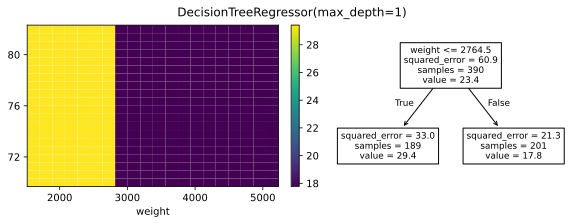

In [212]:
df = pd.read_csv("data/auto_preprocessed.csv")

model = DecisionTreeRegressor(max_depth=1)
model.fit(df[["weight", "year"]], df["mpg"])

w0, w1 = df["weight"].min(), df["weight"].max()
y0, y1 = df["year"].min(), df["year"].max()

W, Y = np.meshgrid(np.linspace(w0, w1, 20), np.linspace(y0, y1, 20))

M = model.predict(pd.DataFrame({"weight": W.ravel(), "year": Y.ravel()})).reshape(
    W.shape
)

fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), layout="constrained")
fig.suptitle("DecisionTreeRegressor(max_depth=1)")
# a0.scatter(x, y, alpha=0.3)
pcolor = a0.pcolormesh(W, Y, M, antialiased=True)
a0.set_xlabel("weight")
a0.set_yticks([72, 76, 80])
a0.set_xticks([2000, 3000, 4000, 5000])
plt.colorbar(pcolor, ax=a0)
plot_tree(model, ax=a1, precision=1, feature_names=model.feature_names_in_)
plt.show()

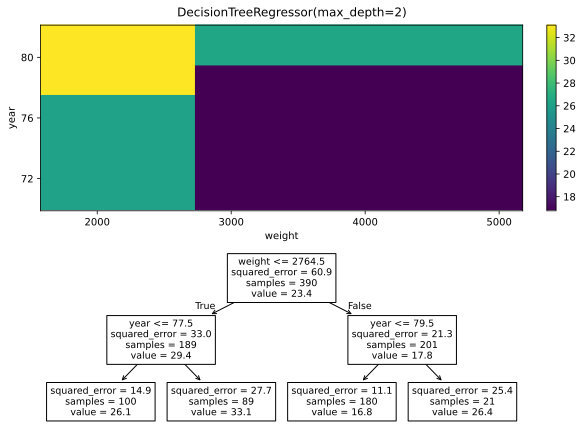

In [215]:
model = DecisionTreeRegressor(max_depth=2)
model.fit(df[["weight", "year"]], df["mpg"])

w0, w1 = df["weight"].min(), df["weight"].max()
y0, y1 = df["year"].min(), df["year"].max()

W, Y = np.meshgrid(np.linspace(w0, w1, 50), np.linspace(y0, y1, 50))

M = model.predict(pd.DataFrame({"weight": W.ravel(), "year": Y.ravel()})).reshape(
    W.shape
)

fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), layout="constrained")
fig.suptitle("DecisionTreeRegressor(max_depth=2)")
pcolor = a0.pcolormesh(W, Y, M, antialiased=True, rasterized=True)
a0.set_xlabel("weight")
a0.set_ylabel("year")
a0.set_yticks([72, 76, 80])
a0.set_xticks([2000, 3000, 4000, 5000])
plt.colorbar(pcolor, ax=a0)
plot_tree(model, ax=a1, precision=1, feature_names=model.feature_names_in_)
plt.show()

In [ ]:
model = DecisionTreeRegressor()
model.fit(df[["weight", "year"]], df["mpg"])

w0, w1 = df["weight"].min(), df["weight"].max()
y0, y1 = df["year"].min(), df["year"].max()

W, Y = np.meshgrid(np.linspace(w0, w1, 20), np.linspace(y0, y1, 20))

M = model.predict(pd.DataFrame({"weight": W.ravel(), "year": Y.ravel()})).reshape(
    W.shape
)

fig, (a0, a1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), layout="constrained")
fig.suptitle("My Second Regression Tree: max_depth=2")
pcolor = a0.pcolor(W, Y, M, snap=True)
a0.set_xlabel("weight")
a0.set_ylabel("year")
a0.set_yticks([72, 76, 80])
a0.set_xticks([2000, 3000, 4000, 5000])
plt.colorbar(pcolor, ax=a0)
plot_tree(model, ax=a1, precision=1, feature_names=model.feature_names_in_)
plt.show()

### Instability

- Decision trees are sensitive to perturbations of their training data.

- For example, the splitting feature depth-one decision trees fit to bootstrap samples of the car dataset depends strongly on the sample.

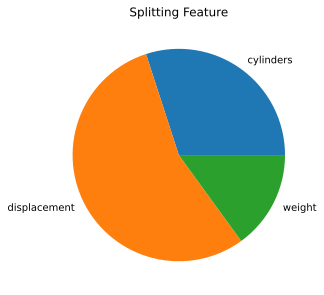

In [278]:
model = DecisionTreeRegressor(max_depth=1)

n_repeats = 100
feature = np.zeros(n_repeats, dtype=int)

for i in range(n_repeats):
    X = df.sample(frac=1, replace=True, random_state=i).copy()
    y = X.pop("mpg")
    model.fit(X, y)
    feature[i] = model.tree_.feature[0]

counter = Counter(X.columns[feature])
plt.pie(counter.values(), labels=counter.keys())
plt.title("Splitting Feature")
plt.show()

### Overfitting

- Due to their high sensitivity to training data perturbations, complex decision trees tend to overfit.

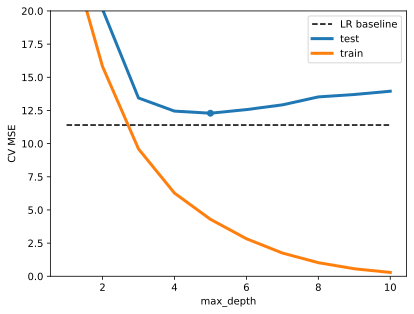

In [327]:
df = pd.read_csv("data/auto_preprocessed.csv")
X = df[[c for c in df.columns if c != "mpg"]]
y = df["mpg"]

model = DecisionTreeRegressor()
param_grid = {"max_depth": np.arange(10) + 1}
search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    cv=RepeatedKFold(n_repeats=50),
)
search.fit(X, y)

lr_cv_mse = -cross_val_score(
    LinearRegression(),
    X,
    y,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=50),
).mean()

plt.plot([1, 10], [lr_cv_mse, lr_cv_mse], "k--", label="LR baseline")

plt.plot(
    search.cv_results_["param_max_depth"],
    -search.cv_results_["mean_test_score"],
    lw=3,
    label="test",
)

plt.plot(
    search.cv_results_["param_max_depth"],
    -search.cv_results_["mean_train_score"],
    lw=3,
    label="train",
)

plt.plot(search.best_params_["max_depth"], -search.best_score_, "C0o")

plt.ylim(0, 20)
plt.xlabel("max_depth")
plt.ylabel("CV MSE")
plt.legend()
plt.show()

### Random Forests

- Combat overfitting by training an ***ensemble*** of decision trees &mdash; a ***random forest*** &mdash; each on a different boostrap replicate of the training set, and averaging their predictions.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("data/auto_preprocessed.csv")
X = df[[c for c in df.columns if c != "mpg"]]
y = df["mpg"]


rf_cv_mse = -cross_val_score(
    RandomForestRegressor(),
    X,
    y,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(),
).mean()

ic(rf_cv_mse)

ic| rf_cv_mse: np.float64(7.684335357692302)


- The `estimators_` attribute of a fit random forest contains a list of the fit decision trees making up the ensemble.

- Let's check that their predictions average out to the predictions of the random forest.

In [456]:
df = pd.read_csv("data/auto_preprocessed.csv")
X = df[[c for c in df.columns if c != "mpg"]]
y = df["mpg"].to_numpy()

model = RandomForestRegressor()
model.fit(X, y)


Y = np.array([e.predict(X.to_numpy()) for e in model.estimators_])
assert np.allclose(Y.mean(axis=0), model.predict(X))

### Feature importances

- `feature_importances_` attribute of a fit decision tree

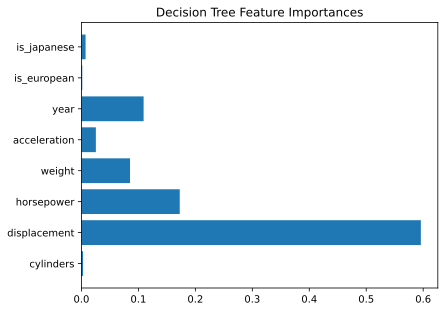

In [ ]:
df = pd.read_csv("data/auto_preprocessed.csv")
X = df[[c for c in df.columns if c != "mpg"]]
y = df["mpg"]

model = DecisionTreeRegressor()
model.fit(X, y)

plt.barh(
    model.feature_names_in_,
    model.feature_importances_,
)
plt.title("Decision Tree Feature Importances")
plt.show()

### How are feature importances computed?

#### The training subset associated with a node

- Each node $n$ in our fit decision tree has an associated subset $\mathcal{D}_n$ of our training set.

- $\mathcal{D}_0$, the subset associated wth the root node $n=0$, is whole training set.

- Let $n$ be a nonleaf node with associated subset $\mathcal{D}$. Let $n^-$ and $n^+$ be the left and right children of $n$, respectively, and let $(j_n^*, s_n^*)$ feature/threshold pair associated to $n$ by the fitting process.
Then
$$
\mathcal{D}_{n^-} = \mathcal{D}_{j_n^*, s_n^*}^-
\qquad\text{and}\qquad
\mathcal{D}_{n^+} = \mathcal{D}_{j_n^*, s_n^*}^+.
$$

#### The sum of squared errors (SSE) associated with a node $n$

$$
\operatorname{SSE}_n = \sum_{(x_i, y_i)\in\mathcal{D}_n} (y_i - \hat{f}_0(x_i\mid \mathcal{D}_n))^2
$$

#### The SSE-decrease associated with a nonleaf-node $n$

$$
\Delta\operatorname{SSE}_n = \operatorname{SSE}_n - (\operatorname{SSE}_{n^-} + \operatorname{SSE}_{n^+})
$$

#### Feature importance

$$
\text{importance of feature $j$} = \frac{\displaystyle\sum_{n\text{ such that }j_n^*=j}\Delta \operatorname{SSE}_n}{\displaystyle\sum_{\text{all}\;n}\Delta \operatorname{SSE}_n}
$$

#### Verification

- See below.

In [ ]:
tree = model.tree_
feature = tree.feature
decision_path = tree.decision_path(X.to_numpy(dtype=np.float32)).toarray().astype(bool)
value = tree.value.squeeze()
children_left = tree.children_left
children_right = tree.children_right

importances = np.zeros(model.n_features_in_)

for node_i in range(tree.node_count):
    if feature[node_i] != -2:  # not a leaf node
        left_child_i = children_left[node_i]
        right_child_i = children_right[node_i]

        data_mask = decision_path[:, node_i]
        sse = np.sum((y[data_mask] - value[node_i]) ** 2)

        data_mask_left = decision_path[:, left_child_i]
        sse_left = np.sum((y[data_mask_left] - value[left_child_i]) ** 2)

        data_mask_right = decision_path[:, right_child_i]
        sse_right = np.sum((y[data_mask_right] - value[right_child_i]) ** 2)

        improvement = sse - (sse_left + sse_right)
        assert improvement >= 0

        importances[feature[node_i]] += improvement

importances /= importances.sum()

assert np.allclose(importances, model.feature_importances_)

- Random forests also have feature importances.

- They're averages of the feature importances of their constituent decision trees.

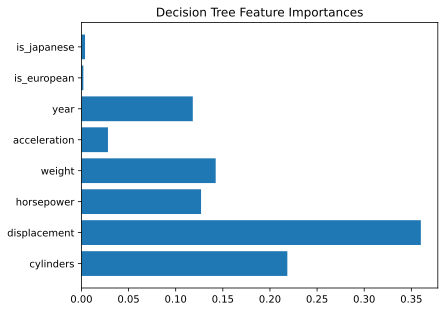

In [ ]:
model = RandomForestRegressor()
model.fit(X, y)

plt.barh(
    model.feature_names_in_,
    model.feature_importances_,
)
plt.title("Decision Tree Feature Importances")
plt.show()

### Bagging

- Clever (?) contraction of **B**ootstrap **agg**regat**ing**.

- An ensemble of models of a common type fit on bootstrap replicates of a common training set.

- Random forests is the most common incarnation of this idea (by far).

In [582]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.813759,0.012932,0.026781,0.001164,squared_error,2,"{'criterion': 'squared_error', 'max_features': 2}",-0.212087,-0.218863,-0.228661,-0.222192,-0.237427,-0.223846,0.008643,3
1,2.531401,0.051844,0.025914,0.000393,squared_error,8,"{'criterion': 'squared_error', 'max_features': 8}",-0.227320,-0.221387,-0.226322,-0.229468,-0.233950,-0.227689,0.004101,4
2,11.889985,0.112207,0.027002,0.000637,absolute_error,2,"{'criterion': 'absolute_error', 'max_features'...",-0.209290,-0.218363,-0.224449,-0.225456,-0.236005,-0.222713,0.008790,2
3,36.880479,0.658084,0.027243,0.000926,absolute_error,8,"{'criterion': 'absolute_error', 'max_features'...",-0.215316,-0.211944,-0.223186,-0.222602,-0.227267,-0.220063,0.005595,1
